In [2]:
from torch_geometric.datasets import BA2MotifDataset

dataset = BA2MotifDataset(root='data/BA2Motif')
dataset = dataset.shuffle()


In [3]:
import ot
import networkx as nx
from torch_geometric.utils import to_dense_adj, to_scipy_sparse_matrix, coalesce
import numpy as np
import torch
from torch_geometric.data import Data
import random

def filter_undirected_edges(edge_index):
    edge_set = set()
    unique_edges = []
    
    for i in range(edge_index.size(1)):
        u, v = sorted(edge_index[:, i].tolist()) 
        edge = (u, v)
        if edge not in edge_set:
            edge_set.add(edge)
            unique_edges.append([u, v])
    
    return torch.tensor(unique_edges, dtype=torch.long).T 

def ensure_undirected(edge_index):
    edge_set = set()
    unique_edges = []
    
    for i in range(edge_index.shape[1]):
        u, v = edge_index[:, i].tolist()
        edge = tuple(sorted((u, v)))
        
        if edge not in edge_set:
            edge_set.add(edge)
            unique_edges.append([u, v])

    bidirectional_edges = []
    for u, v in unique_edges:
        bidirectional_edges.append([u, v])
        bidirectional_edges.append([v, u])
    
    return torch.tensor(bidirectional_edges, dtype=torch.long).T

def pyg_to_fgw_format(graph):
    graph.edge_index = ensure_undirected(graph.edge_index)
    adj = to_dense_adj(graph.edge_index)[0].numpy()
    features = graph.x.numpy()
    p = np.ones(graph.num_nodes) / graph.num_nodes
    
    return adj, features, p

def compute_fgw_distance(graph1, graph2, alpha=0.5):
    # clone graphs
    graph1 = graph1.clone()
    graph2 = graph2.clone()
    C1, features1, p = pyg_to_fgw_format(graph1)
    C2, features2, q = pyg_to_fgw_format(graph2)
    max_nodes = max(features1.shape[0], features2.shape[0])

    # Padding f
    features1 = np.pad(features1, ((0, max_nodes - features1.shape[0]), (0, 0)), mode='constant')
    features2 = np.pad(features2, ((0, max_nodes - features2.shape[0]), (0, 0)), mode='constant')

    C1 = np.pad(C1, ((0, max_nodes - C1.shape[0]), (0, max_nodes - C1.shape[1])), mode='constant')
    C2 = np.pad(C2, ((0, max_nodes - C2.shape[0]), (0, max_nodes - C2.shape[1])), mode='constant')
    
    features1 = features1 / (np.linalg.norm(features1, axis=1, keepdims=True) + 1e-10)
    features2 = features2 / (np.linalg.norm(features2, axis=1, keepdims=True) + 1e-10)
    p = p / np.sum(p)
    q = q / np.sum(q)
    
    M = ot.dist(features1, features2)  
    
    fgw_dist = ot.gromov.fused_gromov_wasserstein2(
        M, C1, C2, p,p,
        loss_fun='square_loss', alpha=alpha
    )
    
    return fgw_dist

In [3]:
graph1 = dataset[4]
graph2 = dataset[4]
graph1 = Data(x=graph1.x, edge_index=filter_undirected_edges(graph1.edge_index))
graph2 = Data(x=graph2.x, edge_index=filter_undirected_edges(graph2.edge_index))
dist = compute_fgw_distance(graph1, graph2, alpha=0.5)
print("Distance:", dist)

Distance: 0.012800000000000002


In [4]:
from model.gin import GIN
from torch_geometric.data import DataLoader
import torch
import random
from torch_geometric.data import Data

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GIN(
    in_channels=dataset.num_features,
    hidden_channels=32,
    out_channels=dataset.num_classes,
    num_layers=5,
).to(device)

model.load_state_dict(torch.load('model/model.pth'))
model.eval()

GIN(
  (convs): ModuleList(
    (0): GINConv(nn=MLP(10, 32, 32))
    (1-4): 4 x GINConv(nn=MLP(32, 32, 32))
  )
  (mlp): MLP(32, 32, 2)
)

In [4]:
def is_connected(edge_index, num_nodes):
        G = nx.Graph()
        G.add_edges_from(edge_index.T.tolist())
        return nx.is_connected(G)

In [5]:
import random
import torch
from torch_geometric.data import Data

class GraphGenome:
    def __init__(self, data):
        self.num_nodes = data.num_nodes
        self.x = data.x.clone()
        self.edge_index = data.edge_index.clone()
        self.fitness = 0
    
    def clone(self):
        return GraphGenome(Data(x=self.x.clone(), edge_index=self.edge_index.clone()))
    
    def eval_fitness_sso(self, graphX, blackbox, distance_function, alpha1, alpha2):
        similarity = 1.0 - distance_function(graphX, self)
        similarity = 0.0 if similarity >= 0.999 else similarity
        
        y_X = blackbox.predict(graphX.x, ensure_undirected(graphX.edge_index), None, 1)
        y_G = blackbox.predict(self.x, ensure_undirected(self.edge_index), None, 1)
        target_similarity = 1.0 if y_X == y_G else 0.0
        
        print('record_similarity: ', similarity, '-- evaluation: ', target_similarity)
        return alpha1 * similarity + alpha2 * target_similarity
    
    def eval_fitness_sdo(self, graphX, blackbox, distance_function, alpha1, alpha2):
        similarity = 1.0 - distance_function(graphX, self)
        similarity = 0.0 if similarity >= 0.999 else similarity
        
        y_X = blackbox.predict(graphX.x, ensure_undirected(graphX.edge_index), None, 1)
        y_G = blackbox.predict(self.x, ensure_undirected(self.edge_index), None, 1)
        target_similarity = 1.0 if y_X != y_G else 0.0
        
        print('record_similarity: ', similarity, '-- evaluation: ', target_similarity)
        return alpha1 * similarity + alpha2 * target_similarity
    
    def eval_fitness_dso(self, graphX, blackbox, distance_function, alpha1, alpha2):
        similarity = 1.0 - distance_function(graphX, self)
        similarity = 0.0 if similarity <= 0.9 else 1 - similarity
        
        y_X = blackbox.predict(graphX.x, ensure_undirected(graphX.edge_index), None, 1)
        y_G = blackbox.predict(self.x, ensure_undirected(self.edge_index), None, 1)
        target_similarity = 1.0 if y_X == y_G else 0.0
        
        print('record_similarity: ', similarity, '-- evaluation: ', target_similarity)
        return alpha1 * similarity + alpha2 * target_similarity
    
    def eval_fitness_ddo(self, graphX, blackbox, distance_function, alpha1, alpha2):
        print('Evaluating fitness...')
        similarity = 1.0 - distance_function(graphX, self)
        similarity = 0.0 if similarity <= 0.9 else 1 - similarity
        
        y_X = blackbox.predict(graphX.x, ensure_undirected(graphX.edge_index), None, 1)
        y_G = blackbox.predict(self.x, ensure_undirected(self.edge_index), None, 1)
        target_similarity = 1.0 if y_X != y_G else 0.0
        
        print('record_similarity: ', similarity, '-- evaluation: ', target_similarity)
        return alpha1 * similarity + alpha2 * target_similarity
    
    def mutate(self, graphX, blackbox, distance_function, alpha1, alpha2, case_type, dataset):
       
        edge_list = set(tuple(edge.tolist()) for edge in self.edge_index.T)
        num_nodes = self.x.size(0)
        
        # them hoac xoa 1 canh
        if random.random() <= 0.5:
            u, v = random.sample(range(num_nodes), 2)
            edge = (u, v) if u < v else (v, u)
            if edge not in edge_list:
                edge_list.add(edge)
        else:  
            if edge_list:
                edge = random.choice(list(edge_list))
                edge_list.remove(edge)
                
        new_edge_index = torch.tensor(list(edge_list), dtype=torch.long).T
        
        # thay doi feature vector cua 1 node
        new_x = self.x.clone()
        mutation_rate = 0.1
        for i in range(num_nodes):
            if random.random() < mutation_rate:
                # other_graph = random.choice(dataset)
                # new_x[i] = other_graph.x[i].clone()
                
                if torch.all((new_x[i] == 0) | (new_x[i] == 1)):  
                    # Nếu x[i] chỉ có 0 và 1 (như MUTAG), dùng bit flipping
                    current_category = torch.argmax(new_x[i]).item()
                    new_category = random.choice([j for j in range(new_x.size(1)) if j != current_category])
                    new_x[i] = torch.zeros_like(new_x[i])
                    new_x[i][new_category] = 1
                else:
                    # Nếu x[i] là giá trị liên tục, thêm nhiễu Gaussian
                    noise = torch.randn_like(new_x[i]) * 0.05
                    new_x[i] = torch.clamp(new_x[i] + noise, 0, 1)
        mutated_graph = GraphGenome(Data(x=new_x, edge_index=new_edge_index))
        
        
        # Evaluate fitness based on case type
        if case_type == 'sso':
            mutated_graph.fitness = mutated_graph.eval_fitness_sso(graphX, blackbox, distance_function, alpha1, alpha2)
        elif case_type == 'sdo':
            mutated_graph.fitness = mutated_graph.eval_fitness_sdo(graphX, blackbox, distance_function, alpha1, alpha2)
        elif case_type == 'dso':
            mutated_graph.fitness = mutated_graph.eval_fitness_dso(graphX, blackbox, distance_function, alpha1, alpha2)
        else:  # 'ddo'
            mutated_graph.fitness = mutated_graph.eval_fitness_ddo(graphX, blackbox, distance_function, alpha1, alpha2)
            
        return mutated_graph
    
    def crossover(self, other, graphX, blackbox, distance_function, alpha1, alpha2, case_type):
        # cat doan edge tu cha va me
        parent1_edges = [tuple(edge.tolist()) for edge in self.edge_index.T]
        parent2_edges = [tuple(edge.tolist()) for edge in other.edge_index.T]

        if len(parent1_edges) < 2 or len(parent2_edges) < 2:
            return self  

        cut1, cut2 = sorted(random.sample(range(len(parent1_edges)), 2))
        child_edges = parent1_edges[:cut1] + parent2_edges[cut1:cut2] + parent1_edges[cut2:]

        child_edges = list(set(tuple(edge) for edge in child_edges))  

        new_edge_index = torch.tensor(child_edges, dtype=torch.long).T

        child = GraphGenome(Data(x=self.x.clone(), edge_index=new_edge_index))
        
        if case_type == 'sso':
            child.fitness = child.eval_fitness_sso(graphX, blackbox, distance_function, alpha1, alpha2)
        elif case_type == 'sdo':
            child.fitness = child.eval_fitness_sdo(graphX, blackbox, distance_function, alpha1, alpha2)
        elif case_type == 'dso':
            child.fitness = child.eval_fitness_dso(graphX, blackbox, distance_function, alpha1, alpha2)
        else:  # 'ddo'
            child.fitness = child.eval_fitness_ddo(graphX, blackbox, distance_function, alpha1, alpha2)

        return child


def initialize_population(size, graph, blackbox, distance_function, alpha1, alpha2, case_type):
    population = [GraphGenome(graph) for _ in range(size)]
    for individual in population:
        if case_type == 'sso':
            individual.fitness = individual.eval_fitness_sso(graph, blackbox, distance_function, alpha1, alpha2)
        elif case_type == 'sdo':
            individual.fitness = individual.eval_fitness_sdo(graph, blackbox, distance_function, alpha1, alpha2)
        elif case_type == 'dso':
            individual.fitness = individual.eval_fitness_dso(graph, blackbox, distance_function, alpha1, alpha2)
        else:  # 'ddo'
            individual.fitness = individual.eval_fitness_ddo(graph, blackbox, distance_function, alpha1, alpha2)
            
    return population

def select_parents(population, ratio):
    population.sort(key=lambda individual: individual.fitness, reverse=True)
    return population[:int(ratio * len(population))]

def genetic_algorithm(graphX, populationSize, generations, blackbox, distance_function, alpha1, alpha2, dataset):
    case_population_size = populationSize // 2
    case_type = ['sso', 'sdo']
    populations = {}
        
    for type in case_type:
        populations[type] = initialize_population(
                    case_population_size, graphX, blackbox, distance_function, alpha1, alpha2, type
                )
        for gen in range(generations):
            print(f"\n===== {type} : Generation {gen+1}/{generations} =====")
            new_population = []
            best_individuals = select_parents(populations[type], 0.4)
            new_population.extend(best_individuals[:len(best_individuals) // 2])
            while len(new_population) < case_population_size:
                parent1, parent2 = random.sample(best_individuals, 2)
                child = parent1.crossover(parent2, graphX, blackbox, distance_function, alpha1, alpha2, type)
                if random.random() < 0.2:
                    child = child.mutate(graphX, blackbox, distance_function, alpha1, alpha2, type, dataset)
                new_population.append(child)
                    
            populations[type] = new_population
            
    final_population = []
    for population in populations.values():
        final_population.extend(population)
        
    return final_population

In [142]:
from distance import *
graphX = dataset[2]
graphX = Data(x=graphX.x, edge_index=filter_undirected_edges(graphX.edge_index))
print("Graph X:", graphX.edge_index.T.tolist())

final_population = genetic_algorithm(graphX = graphX, populationSize=400, generations=10, blackbox=model, 
                                     distance_function=fgw_distance, 
                                     alpha1=0.5, alpha2=0.5, dataset=dataset)


Graph X: [[0, 1], [0, 20], [1, 2], [1, 4], [1, 5], [1, 6], [1, 8], [1, 14], [2, 3], [2, 9], [4, 10], [4, 15], [5, 7], [5, 17], [7, 18], [9, 11], [9, 12], [9, 13], [9, 16], [14, 19], [20, 21], [20, 23], [20, 24], [21, 22], [21, 24], [22, 23]]
record_similarity:  0.9968 -- evaluation:  1.0
record_similarity:  0.9968 -- evaluation:  1.0
record_similarity:  0.9968 -- evaluation:  1.0
record_similarity:  0.9968 -- evaluation:  1.0
record_similarity:  0.9968 -- evaluation:  1.0
record_similarity:  0.9968 -- evaluation:  1.0
record_similarity:  0.9968 -- evaluation:  1.0
record_similarity:  0.9968 -- evaluation:  1.0
record_similarity:  0.9968 -- evaluation:  1.0
record_similarity:  0.9968 -- evaluation:  1.0
record_similarity:  0.9968 -- evaluation:  1.0
record_similarity:  0.9968 -- evaluation:  1.0
record_similarity:  0.9968 -- evaluation:  1.0
record_similarity:  0.9968 -- evaluation:  1.0
record_similarity:  0.9968 -- evaluation:  1.0
record_similarity:  0.9968 -- evaluation:  1.0
record

In [6]:
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt

index = random.randint(0, len(final_population) - 1)
print("Fitness:", final_population[index].fitness)
graph_neig = Data(x=final_population[index].x, edge_index=final_population[index].edge_index)

def layout(G):
    return nx.spring_layout(G, seed=42)

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title("Original Graph")
G_original = to_networkx(graphX, to_undirected=True)
pos = layout(G_original)  
nx.draw(G_original, with_labels=True, pos=pos)

plt.subplot(122)
plt.title("Mutated Graph")
plt.text(0.5, 0.5, "Fitness: {:.4f}".format(final_population[index].fitness), fontsize=12)
G_mutated = to_networkx(graph_neig, to_undirected=True)
nx.draw(G_mutated, with_labels=True, pos=pos)
plt.show()

NameError: name 'final_population' is not defined

In [9]:
print(dataset[2].edge_index)
edge_index = filter_undirected_edges(dataset[2].edge_index)
full_edge_index = ensure_undirected(edge_index)
print(full_edge_index)
pred_data = Data(x= dataset[2].x, edge_index=ensure_undirected(edge_index))
pred = model.predict(pred_data.x, pred_data.edge_index, None, 1)
pred

tensor([[ 0,  0,  0,  1,  1,  1,  1,  1,  1,  2,  2,  2,  3,  3,  4,  4,  5,  6,
          6,  6,  6,  7,  7,  8,  9, 10, 11, 12, 12, 12, 13, 14, 15, 16, 16, 17,
         17, 18, 19, 20, 20, 20, 21, 21, 22, 22, 23, 23, 24, 24],
        [ 1,  6, 20,  0,  2,  3,  5,  7, 13,  1,  4, 11,  1, 15,  2, 10,  1,  0,
          8, 12, 16,  1,  9,  6,  7,  4,  2,  6, 14, 17,  1, 12,  3,  6, 19, 12,
         18, 17, 16,  0, 21, 24, 20, 22, 21, 23, 22, 24, 20, 23]])
tensor([[ 0,  1,  0,  6,  0, 20,  1,  2,  1,  3,  1,  5,  1,  7,  1, 13,  2,  4,
          2, 11,  3, 15,  4, 10,  6,  8,  6, 12,  6, 16,  7,  9, 12, 14, 12, 17,
         16, 19, 17, 18, 20, 21, 20, 24, 21, 22, 22, 23, 23, 24],
        [ 1,  0,  6,  0, 20,  0,  2,  1,  3,  1,  5,  1,  7,  1, 13,  1,  4,  2,
         11,  2, 15,  3, 10,  4,  8,  6, 12,  6, 16,  6,  9,  7, 14, 12, 17, 12,
         19, 16, 18, 17, 21, 20, 24, 20, 22, 21, 23, 22, 24, 23]])


tensor([0])

In [169]:
import pandas as pd
import torch
import numpy as np

def create_adjacency_matrix(edge_index, num_nodes):
    adj_matrix = torch.zeros((num_nodes, num_nodes), dtype=torch.int)
    if edge_index.numel() > 0:  
        for i in range(edge_index.size(1)):
            src, dst = edge_index[0, i].item(), edge_index[1, i].item()
            adj_matrix[src, dst] = 1
            adj_matrix[dst, src] = 1
    return adj_matrix

def prepare_dataframe(list_graph, model, device, ground_truth = False, only_edge = False):
    all_embeddings = []
    edge_dicts = []
    labels = []
    
    model.eval() 
    
    with torch.no_grad():
        for graph in list_graph:
            x = graph.x.to(device)
            edge_index = ensure_undirected(graph.edge_index).to(device)

            # tinh node embeddings va lay mean
            _, node_embeddings = model(x, edge_index, None, 1, return_embeddings=True)
            mean_node_embedding = node_embeddings.mean(dim=1).cpu().numpy()
            all_embeddings.append(mean_node_embedding.tolist())
            
            # tao ma tran ke va chuyen thanh dict
            num_nodes = graph.num_nodes
            adj_matrix = create_adjacency_matrix(graph.edge_index.cpu(), num_nodes)
            edge_dict = {f'n{r}_n{c}': adj_matrix[r, c].item() 
                         for r in range(num_nodes) for c in range(r, num_nodes)}
            edge_dicts.append(edge_dict)
            
            if ground_truth:
                labels.append(graph.y.item())
            else :
                prediction = model.predict(x, edge_index, None, 1)
                labels.append(prediction.item())
                

    max_embed_dim = max(len(embed) for embed in all_embeddings)
    embed_columns = [f'nE_{i}' for i in range(max_embed_dim)]
    
    if only_edge:
        result_df = pd.DataFrame(edge_dicts).fillna(0).astype(int)
    else:
        df_embeddings = pd.DataFrame(all_embeddings, columns=embed_columns)
        df_edges = pd.DataFrame(edge_dicts).fillna(0).astype(int)
        result_df = pd.concat([df_embeddings, df_edges], axis=1)
    result_df['y'] = labels
    
    return result_df

df = prepare_dataframe(final_population, model, device, ground_truth=False, only_edge=True)
df.head()

,n0_n0,n0_n1,n0_n2,n0_n3,n0_n4,n0_n5,n0_n6,n0_n7,n0_n8,n0_n9,...,n21_n22,n21_n23,n21_n24,n22_n22,n22_n23,n22_n24,n23_n23,n23_n24,n24_n24,y
0,0,1,0,0,0,0,0,0,0,0,...,1,0,1,0,1,0,0,0,0,1
1,0,1,0,0,0,0,0,0,0,0,...,1,0,1,0,1,0,0,0,0,1
2,0,1,0,0,0,0,0,0,0,0,...,1,0,1,0,1,0,0,0,0,1
3,0,1,0,0,0,0,0,0,0,0,...,1,0,1,0,1,0,0,0,0,1
4,0,1,0,0,0,0,0,0,0,0,...,1,0,1,0,1,0,0,0,0,1


In [170]:
# count number of row has y = 1
class_1 = df[df['y'] == 1].shape[0]
class_0 = df[df['y'] == 0].shape[0]
class_1, class_0


(192, 208)

In [12]:
df[:5]

,nE_1,nE_2,nE_3,nE_4,nE_5,nE_6,nE_7,nE_8,nE_9,nE_10,...,n21_n22,n21_n23,n21_n24,n22_n22,n22_n23,n22_n24,n23_n23,n23_n24,n24_n24,y
0,0.048385,0.005581,0.012235,0.015779,0.028349,0.028349,0.025025,0.016052,0.053891,0.026382,...,1,0,0,0,1,0,0,1,0,0
1,0.048385,0.005581,0.012235,0.015779,0.028349,0.025025,0.028349,0.016052,0.053891,0.026382,...,1,0,0,0,1,0,0,1,0,0
2,0.049518,0.006127,0.012429,0.015695,0.027352,0.027352,0.027352,0.015773,0.053990,0.026373,...,1,0,0,0,1,0,0,1,0,0
3,0.043378,0.008445,0.012640,0.015963,0.027083,0.027083,0.027083,0.014900,0.048158,0.029757,...,1,0,0,0,1,0,0,1,0,0
4,0.032964,0.007567,0.012677,0.015395,0.026950,0.026950,0.026950,0.014318,0.023060,0.026723,...,1,0,0,0,1,0,0,1,0,0


In [13]:
df.to_pickle("generate_sample.pkl")

In [14]:
df_loaded = pd.read_pickle("generate_sample.pkl")
df_loaded.shape


(1000, 351)

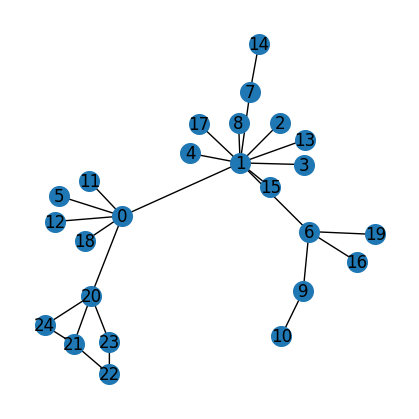

In [9]:
import pickle
def load_graphs_from_pickle(filename = "graph2X.pkl"):
    with open(filename, "rb") as f:
        return pickle.load(f)

loaded_graphs = load_graphs_from_pickle("graph2X.pkl")
G = to_networkx(loaded_graphs, to_undirected=True)
plt.figure(figsize=(4, 4))
nx.draw(G, with_labels=True, cmap="coolwarm", node_size=200)
plt.show()

In [16]:
from torch_geometric.datasets import TUDataset
from torch_geometric.data import DataLoader
mutag = TUDataset(root="TUDataset", name="MUTAG")

In [17]:
def pad_matrix(matrix, target_size):
    pad_size = target_size - matrix.shape[0]
    if pad_size > 0:
        pad_matrix = torch.zeros((pad_size, matrix.shape[1]), dtype=matrix.dtype, device=matrix.device)
        matrix = torch.cat([matrix, pad_matrix], dim=0)
        
        pad_matrix = torch.zeros((matrix.shape[0], pad_size), dtype=matrix.dtype, device=matrix.device)
        matrix = torch.cat([matrix, pad_matrix], dim=1)
    return matrix

def pad_features(features, target_size):
    pad_size = target_size - features.shape[0]
    if pad_size > 0:
        pad_matrix = torch.zeros((pad_size, features.shape[1]), dtype=features.dtype, device=features.device)
        features = torch.cat([features, pad_matrix], dim=0)
    return features

def my_distance(data1, data2, adj_weight=0.5, feature_weight=0.5, normalize=True):
    max_nodes = max(data1.num_nodes, data2.num_nodes)

    # Chuyển edge_index thành ma trận kề
    data1.edge_index = ensure_undirected(data1.edge_index)
    data2.edge_index = ensure_undirected(data2.edge_index)
    
    adj1 = torch.zeros((data1.num_nodes, data1.num_nodes), dtype=torch.float32)
    adj1[data1.edge_index[0], data1.edge_index[1]] = 1
    adj1 = pad_matrix(adj1, max_nodes)

    adj2 = torch.zeros((data2.num_nodes, data2.num_nodes), dtype=torch.float32)
    adj2[data2.edge_index[0], data2.edge_index[1]] = 1
    adj2 = pad_matrix(adj2, max_nodes)

    # Tính khoảng cách Frobenius giữa ma trận kề
    adj_distance = torch.norm(adj1 - adj2, p='fro')

    # Padding feature matrix 
    if data1.x is not None and data2.x is not None:
        feature_dim = data1.x.shape[1]  # Giữ nguyên số chiều đặc trưng
        feature1 = pad_features(data1.x, max_nodes)
        feature2 = pad_features(data2.x, max_nodes)
        feature_distance = torch.norm(feature1 - feature2, p='fro')
    else:
        feature_distance = torch.tensor(0.0)

    # Chuẩn hóa khoảng cách về [0,1]
    if normalize:
        max_adj_dist = torch.norm(torch.ones_like(adj1), p='fro')  # Khoảng cách tối đa có thể có
        max_feat_dist = torch.norm(torch.ones_like(feature1), p='fro') if data1.x is not None else 1.0

        adj_distance = adj_distance / max_adj_dist
        feature_distance = feature_distance / max_feat_dist

    total_distance = adj_weight * adj_distance + feature_weight * feature_distance

    return {
        "adj_distance": adj_distance.item(),
        "feature_distance": feature_distance.item(),
        "total_distance": total_distance.item()
    }

In [18]:
A = dataset[0]
B = dataset[1]
parent1_edges = list((tuple(edge.tolist()) for edge in filter_undirected_edges(A.edge_index).T))
parent2_edges = list((tuple(edge.tolist()) for edge in filter_undirected_edges(B.edge_index).T))
print(parent1_edges)
print(parent2_edges)
 
cut1, cut2 = sorted(random.sample(range(len(parent1_edges)), 2))
print("Cut: ",cut1, cut2)
child_edges = parent1_edges[:cut1] + parent2_edges[cut1:cut2] + parent1_edges[cut2:]
child_edges = list(child_edges)
print("Child: ", child_edges)
new_edge_index = torch.tensor(child_edges, dtype=torch.long).T
print(new_edge_index)

[(0, 1), (0, 2), (0, 20), (2, 3), (2, 7), (2, 8), (2, 9), (2, 14), (2, 15), (3, 4), (3, 5), (5, 6), (5, 12), (6, 13), (7, 10), (7, 11), (7, 16), (7, 17), (7, 18), (14, 19), (20, 21), (20, 24), (21, 22), (22, 23), (23, 24)]
[(0, 1), (0, 20), (1, 2), (1, 6), (1, 14), (1, 18), (2, 3), (2, 4), (2, 5), (2, 10), (4, 9), (4, 12), (5, 16), (6, 7), (6, 8), (6, 15), (6, 19), (9, 11), (11, 13), (14, 17), (20, 21), (20, 23), (20, 24), (21, 22), (21, 24), (22, 23)]
Cut:  11 15
Child:  [(0, 1), (0, 2), (0, 20), (2, 3), (2, 7), (2, 8), (2, 9), (2, 14), (2, 15), (3, 4), (3, 5), (4, 12), (5, 16), (6, 7), (6, 8), (7, 11), (7, 16), (7, 17), (7, 18), (14, 19), (20, 21), (20, 24), (21, 22), (22, 23), (23, 24)]
tensor([[ 0,  0,  0,  2,  2,  2,  2,  2,  2,  3,  3,  4,  5,  6,  6,  7,  7,  7,
          7, 14, 20, 20, 21, 22, 23],
        [ 1,  2, 20,  3,  7,  8,  9, 14, 15,  4,  5, 12, 16,  7,  8, 11, 16, 17,
         18, 19, 21, 24, 22, 23, 24]])


In [ ]:
df = prepare_dataframe(dataset, model, device, 

tensor([[ 0,  0,  0,  2,  2,  2,  2,  2,  2,  3,  3,  5,  5,  6,  7,  7,  7,  7,
          7, 14, 20, 20, 21, 22, 23],
        [ 1,  2, 20,  3,  7,  8,  9, 14, 15,  4,  5,  6, 12, 13, 10, 11, 16, 17,
         18, 19, 21, 24, 22, 23, 24]])
[(0, 1), (0, 2), (0, 20), (2, 3), (2, 7), (2, 8), (2, 9), (2, 14), (2, 15), (3, 4), (3, 5), (5, 6), (5, 12), (6, 13), (7, 10), (7, 11), (7, 16), (7, 17), (7, 18), (14, 19), (20, 21), (20, 24), (21, 22), (22, 23), (23, 24)]


tensor([[ 0,  0,  0,  2,  2,  2,  2,  2,  2,  3,  3,  5,  5,  6,  7,  7,  7,  7,
          7, 14, 20, 20, 22, 23],
        [ 1,  2, 20,  3,  7,  8,  9, 14, 15,  4,  5,  6, 12, 13, 10, 11, 16, 17,
         18, 19, 21, 24, 23, 24]])

In [10]:
import torch
mps_device = torch.device("mps")
x = torch.ones(5, device="mps")
x.device

RuntimeError: The MPS backend is supported on MacOS 13.0+.Current OS version can be queried using `sw_vers`